<a href="https://colab.research.google.com/github/KOMBOU12/Marius/blob/main/Projet4_BERT_SQUAD_interpret.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Interprétabilité d'un modèle transformer**


In [ ]:
# install required python packages
!pip install seaborn
!pip install pandas
!pip install matplotlib
!pip install transformers
!pip install captum
#mecab
!apt install aptitude swig
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3==0.996.3

#neologd
# !git clone --depth 1 https://github.com/neologd/mecab-ipadic-neologd.git
# !echo yes | mecab-ipadic-neologd/bin/install-mecab-ipadic-neologd -n -a

!pip install transformers
!pip install fugashi==1.1.0 ipadic==1.0.0

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
/bin/bash: line 1: aptitude: command not found
  Using cached mecab-python3-0.996.3.tar.gz (63 kB)
  Preparing metadata (setup.py) ... rror
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [63 lines of output]
      /opt/conda/lib/python3.12/site-packages/setuptools/__init__.py:94: _DeprecatedInstaller: setuptools.installer and fetch_build_eggs are deprecated.
      !!
      
              ********************************************************************************
              Requirements should be satisfied by a PEP 517 installer.
              If you are using pip, you can try `pip install --use-pep517`.
              ********************************************************************************
      
      !!
        dist.fetch_bui

Nous importons les packages utiles.

BertTokenizer est le tokenizer des modèles BERT : il permet de tokeniser le texte en entrée pour le modèle BERT.

BertForQuestionAnswering charge un modèle BERT spécialement conçu pour répondre aux questions.

Et BertConfig fournit la configuration pour un modèle BERT, ce qui permet de modifier ses hyperparamètres

captum.attr est une bibliothèque d'explicabilité de PyTorch :

- visualization fournit des outils pour visualiser l'importance des caractéristiques du modèle.
- LayerConductance mesure l'importance des contributions d'une couche spécifique du modèle aux prédictions.
- LayerIntegratedGradients implémente la méthode des gradients intégrés - il s'agit d'une technique qui attribue des scores d'importance aux entrées du modèle. Ce, en intégrant les gradients le long d'un chemin entre une entrée "de base" ou encore "neutre", et l'entrée réelle.
C'est l'article "Axiomatic Attribution for Deep Networks" de Mukund Sundararajan, Ankur Taly et Qiqi Yan (https://arxiv.org/abs/1703.01365) qui expose cette méthode.

Cette méthode permet de quantifier, pour un modèle de NLP, l'importance de chaque entrée de ce modèle dans la prédiction finale.
Son principe est le calcul des gradients du modèle le long d'un chemin interpolé entre une entrée de référence (entrée "neutre") et l'entrée réelle.

Plus précisément, pour une entrée x_i :

IG_i(x) = (x_i - x_i^{(base)}) \times \int_{\alpha=0}^{1} \frac{\partial F(x^{(base)} + \alpha (x - x^{(base)}))}{\partial x_i} d\alpha

où :

- x est l'entrée (input) réelle du modèle
- x^{(base)} est l'entrée "neutre" ou "de base" (en pratique : un vecteur nul ou aléatoire)
- F(x) est la sortie du modèle correspondant à cet input (par exemple, la probabilité d'une classe).
- \alpha est un facteur d'interpolation entre x^{(base)} et x.

La méthode donne une mesure **robuste** de l'importance de chaque entrée.

Dans Captum, LayerIntegratedGradients est utilisé pour interpréter une couche spécifique d'un modèle.

- On choisit une couche cible : Par exemple, la couche d'embedding de BERT.
- puis on définit une entrée de base : Par exemple, un texte constitué uniquement de tokens [PAD] ou d'embeddings nuls.
- ensuite, on interpole cette entrée de base et l'entrée réelle entre elles, en créant plusieurs versions intermédiaires.
- on calcule les gradients pour chaque version intermédiaire par rapport à la sortie du modèle.
- enfin, on intègre ces gradients pour obtenir une attribution finale par input (dans cet exemple de la couche d'embedding, par token).

Ici, pour BERT dans une tâche de question-réponse, on peut par exemple utiliser LayerIntegratedGradients sur la couche d'embedding pour voir quels mots influencent le plus la réponse.

In [ ]:
pip install --upgrade jupyter ipywidgets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import required python libraries
import numpy as np # multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays
import pandas as pd # data manipulation and analysis
import seaborn as sns # statistical data visualization
import matplotlib.pyplot as plt # object-oriented API for embedding plots

import torch # data structures for multi-dimensional tensors and defines mathematical operations over these tensors
import torch.nn as nn # basic building blocks for graphs
import json

# from transformers import pipeline
from transformers import BertTokenizer, BertForQuestionAnswering, BertConfig # library for transformer models
from captum.attr import visualization as viz # captum visualization tool for matplotlib figure, it visualizes attribution for a given image by normalizing attribution values of the desired sign
from captum.attr import LayerConductance, LayerIntegratedGradients # computes conductance with respect to the given layer and provides integrated gradients augmenting accuracy metrics, model debugging and feature or rule extraction.


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Nous effectuons un fine-tuning du modèle BERT sur le jeu de données SQuAD. Ici, le fine tuning est réalisé sur un modèle bert-base-uncased pré-entraîné.

Après avoir fine-tuné ce modèle, nous pouvons charger respectivement le tokenizer et le modèle BERT pré-entraîné en utilisant les commandes BertForQuestionAnswering et BertTokenizer.

D'abord, nous chargeons le modèle et effectuons la tokenisation du texte :

In [ ]:
# replace <bert-case-uncased> with the path of the saved model
# https://huggingface.co/bert-base-uncased
model_path = 'bert-base-uncased'

#model_path = 'digitalepidemiologylab/covid-twitter-bert-v2'

# pipe = pipeline(task='fill-mask', model='digitalepidemiologylab/covid-twitter-bert-v2')
# out = pipe(f"In places with a lot of people, it's a good idea to wear a {pipe.tokenizer.mask_token}")
# print(json.dumps(out, indent=4))
# [
#     {
#         "sequence": "[CLS] in places with a lot of people, it's a good idea to wear a mask [SEP]",
#         "score": 0.9998226761817932,
#         "token": 7308,
#         "token_str": "mask"
#     },
#     ...
# ]


# load model
model = BertForQuestionAnswering.from_pretrained(model_path)
model.to(device)
model.eval()
model.zero_grad()

# load tokenizer
tokenizer = BertTokenizer.from_pretrained(model_path)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Puis nous créons les fonctions :

- predict, qui prend en entrée les tokens prétraités (inputs) ainsi que des métadonnées facultatives (token_type_ids, position_ids, attention_mask), fait passer ces données au modèle BERT pré-entraîné (model), et retourne les logits (start_logits, end_logits) qui seront utilisés pour déterminer où commence et où se termine la réponse dans le texte.

- squad_pos_forward_fun, qui est utilisée pour extraire et retourner la valeur maximale des logits (start_logits ou end_logits) produits par le modèle BERT pour une tâche de Question Answering. Cela permet d'indiquer où la réponse est la plus probable, et facilite l'interprétation de ce modèle en donnant son score de confiance sur le début et la fin de la réponse.

- construct_input_ref_pair, qui prépare deux séquences d'entrées pour notre modèle BERT de Question Answering : la séquence "de base" et l'entrée réelle dont on veut étudier l'importance dans la génération de la réponse.

- construct_input_ref_token_type_pair, qui crée des séquences de token types (token_type_ids et ref_token_type_ids), qui indiquent à quel segment chaque token appartient (question ou texte) et crée également une séquence de référence pour la comparaison. Elle partage un objectif similaire à celui de la fonction précédente, mais elle en diffère dans son approche et par les éléments qu'elle manipule.

- construct_input_ref_pos_id_pair, qui ajoute des informations de position aux tokens.

- construct_attention_mask(input_ids), qui génère un masque d'attention pour le modèle. Un masque d'attention est utilisé pour indiquer au modèle quels tokens doivent être pris en compte et lesquels doivent être ignorés lors du calcul de l'attention. Par exemple, les tokens de padding (qui n'ont pas d'information utile) sont à ignorer.

- construct_whole_bert_embeddings(input_ids, ref_input_ids, token_type_ids=None, ref_token_type_ids=None, position_ids=None, ref_position_ids=None), qui génère les embeddings des tokens à partir de l'entrée réelle et de la référence (en utilisant les embeddings du modèle BERT).


In [ ]:
def predict(inputs, token_type_ids=None, position_ids=None, attention_mask=None):
    output = model(inputs, token_type_ids=token_type_ids,
                 position_ids=position_ids, attention_mask=attention_mask, )
    return output.start_logits, output.end_logits

In [ ]:
def squad_pos_forward_func(inputs, token_type_ids=None, position_ids=None, attention_mask=None, position=0):
    pred = predict(inputs,
                   token_type_ids=token_type_ids,
                   position_ids=position_ids,
                   attention_mask=attention_mask)
    pred = pred[position]
    return pred.max(1).values

In [ ]:
ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

In [ ]:
def construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id):
    question_ids = tokenizer.encode(question, add_special_tokens=False)
    text_ids = tokenizer.encode(text, add_special_tokens=False)

    # construct input token ids
    input_ids = [cls_token_id] + question_ids + [sep_token_id] + text_ids + [sep_token_id]

    # construct reference token ids
    ref_input_ids = [cls_token_id] + [ref_token_id] * len(question_ids) + [sep_token_id] + \
        [ref_token_id] * len(text_ids) + [sep_token_id]

    return torch.tensor([input_ids], device=device), torch.tensor([ref_input_ids], device=device), len(question_ids)

def construct_input_ref_token_type_pair(input_ids, sep_ind=0):
    seq_len = input_ids.size(1)
    token_type_ids = torch.tensor([[0 if i <= sep_ind else 1 for i in range(seq_len)]], device=device)
    ref_token_type_ids = torch.zeros_like(token_type_ids, device=device)# * -1
    return token_type_ids, ref_token_type_ids

def construct_input_ref_pos_id_pair(input_ids):
    seq_length = input_ids.size(1)
    position_ids = torch.arange(seq_length, dtype=torch.long, device=device)
    # we could potentially also use random permutation with `torch.randperm(seq_length, device=device)`
    ref_position_ids = torch.zeros(seq_length, dtype=torch.long, device=device)

    position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
    ref_position_ids = ref_position_ids.unsqueeze(0).expand_as(input_ids)
    return position_ids, ref_position_ids

def construct_attention_mask(input_ids):
    return torch.ones_like(input_ids)

def construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                    token_type_ids=None, ref_token_type_ids=None, \
                                    position_ids=None, ref_position_ids=None):
    input_embeddings = model.bert.embeddings(input_ids, token_type_ids=token_type_ids, position_ids=position_ids)
    ref_input_embeddings = model.bert.embeddings(ref_input_ids, token_type_ids=token_type_ids, position_ids=position_ids)

    return input_embeddings, ref_input_embeddings

On définit une paire question-contexte (ou texte) comme entrée pour notre modèle BERT, pour ensuite interpréter ce sur quoi le modèle se concentre lorsqu'il prédit une réponse à la question à partir du contexte d'entrée donné :

In [ ]:
question, text = "What is an mRNA vaccine ?", "An nRNA vaccine is a type of vaccine that uses messenger RNA (mRNA) to instruct cells in the body to produce a protein that triggers an immune response."
#question, text = "Why should people wear masks?", "Masks are a key measure to suppress transmission and save lives."

On intègre la question et le texte d'entrée. On génère les références/bases correspondantes. La fonction construct_whole_bert_embeddings définie ci-dessus intègre les mots, la fonction construct_input_ref_pos_id_pair intègre les positions, et la fonction construct_input_ref_token_type_pair les tokens :

In [ ]:
input_ids, ref_input_ids, sep_id = construct_input_ref_pair(question, text, ref_token_id, sep_token_id, cls_token_id)
token_type_ids, ref_token_type_ids = construct_input_ref_token_type_pair(input_ids, sep_id)
position_ids, ref_position_ids = construct_input_ref_pos_id_pair(input_ids)
attention_mask = construct_attention_mask(input_ids)

indices = input_ids[0].detach().tolist()
all_tokens = tokenizer.convert_ids_to_tokens(indices)

Définition de la "vérité de terrain" pour les positions de début et de fin de la prédiction :

In [ ]:
ground_truth = 'produce a protein that triggers an immune response.'
#ground_truth = 'key measure to suppress transmission and save lives.'

ground_truth_tokens = tokenizer.encode(ground_truth, add_special_tokens=False)
ground_truth_end_ind = indices.index(ground_truth_tokens[-1])
ground_truth_start_ind = ground_truth_end_ind - len(ground_truth_tokens) + 1

Pour obtenir notre prédiction, nous utilisons l'entrée, le type de token, l'ID de position et le masque d'attention par défaut précédemment calculé :

In [ ]:
start_scores, end_scores = predict(input_ids, \
                                   token_type_ids=token_type_ids, \
                                   position_ids=position_ids, \
                                   attention_mask=attention_mask)


print('Question: ', question)
print('Predicted Answer: ', ' '.join(all_tokens[torch.argmax(start_scores) : torch.argmax(end_scores)+1]))

Question:  What is an mRNA vaccine ?
Predicted Answer:  


Il existe deux manières différentes de calculer les attributions pour les couches d'intégration. La première option consiste à utiliser LayerIntegratedGradients et à calculer les attributions par rapport à BertEmbedding. La deuxième option consiste à utiliser LayerIntegratedGradients pour chaque type d'embedding — word_embeddings, token_type_embeddings, et position_embeddings — et à calculer les attributions par rapport à chaque vecteur d'embedding :

In [ ]:
lig = LayerIntegratedGradients(squad_pos_forward_func, model.bert.embeddings)

attributions_start, delta_start = lig.attribute(inputs=input_ids,
                                  baselines=ref_input_ids,
                                  additional_forward_args=(token_type_ids, position_ids, attention_mask, 0),
                                  return_convergence_delta=True)
attributions_end, delta_end = lig.attribute(inputs=input_ids, baselines=ref_input_ids,
                                additional_forward_args=(token_type_ids, position_ids, attention_mask, 1),
                                return_convergence_delta=True)


Nous créons ensuite une fonction auxiliaire pour résumer les attributions pour chaque token de mot dans la séquence : summarize_attributions.

In [ ]:
def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / torch.norm(attributions)
    return attributions

In [ ]:
attributions_start_sum = summarize_attributions(attributions_start)
attributions_end_sum = summarize_attributions(attributions_end)

In [ ]:
# storing couple samples in an array for visualization purposes
start_position_vis = viz.VisualizationDataRecord(
                        attributions_start_sum,
                        torch.max(torch.softmax(start_scores[0], dim=0)),
                        torch.argmax(start_scores),
                        torch.argmax(start_scores),
                        str(ground_truth_start_ind),
                        attributions_start_sum.sum(),
                        all_tokens,
                        delta_start)

end_position_vis = viz.VisualizationDataRecord(
                        attributions_end_sum,
                        torch.max(torch.softmax(end_scores[0], dim=0)),
                        torch.argmax(end_scores),
                        torch.argmax(end_scores),
                        str(ground_truth_end_ind),
                        attributions_end_sum.sum(),
                        all_tokens,
                        delta_end)

print('\033[1m', 'Visualizations For Start Position', '\033[0m')
viz.visualize_text([start_position_vis])

print('\033[1m', 'Visualizations For End Position', '\033[0m')
viz.visualize_text([end_position_vis])

 Visualizations For Start Position 


 Visualizations For End Position 


L'analyse montre, dans la question, l'importance positive du mot "mrna" pour le choix de la réponse.

In [ ]:
lig2 = LayerIntegratedGradients(squad_pos_forward_func, \
                                [model.bert.embeddings.word_embeddings, \
                                 model.bert.embeddings.token_type_embeddings, \
                                 model.bert.embeddings.position_embeddings])

attributions_start = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 0))
attributions_end = lig2.attribute(inputs=(input_ids, token_type_ids, position_ids),
                                  baselines=(ref_input_ids, ref_token_type_ids, ref_position_ids),
                                  additional_forward_args=(attention_mask, 1))

attributions_start_word = summarize_attributions(attributions_start[0])
attributions_end_word = summarize_attributions(attributions_end[0])

attributions_start_token_type = summarize_attributions(attributions_start[1])
attributions_end_token_type = summarize_attributions(attributions_end[1])

attributions_start_position = summarize_attributions(attributions_start[2])
attributions_end_position = summarize_attributions(attributions_end[2])

/opt/conda/lib/python3.12/site-packages/captum/attr/_core/layer/layer_integrated_gradients.py:101: UserWarning: Multiple layers provided. Please ensure that each layer is**not** solely dependent on the outputs ofanother layer. Please refer to the documentation for moredetail.
  warnings.warn(


Le script ci-dessus utilise LayerIntegratedGradients pour expliquer les prédictions du modèle BERT en calculant l'importance des tokens pour la prédiction des positions de début
et de fin dans un contexte de question-réponse.
Les attributions sont calculées pour les mots, les types de tokens et les positions des tokens, et sont ensuite résumées pour comprendre l'impact de chaque partie de
l'entrée sur la prédiction du modèle.

In [ ]:
def get_topk_attributed_tokens(attrs, k=5):
    values, indices = torch.topk(attrs, k)
    top_tokens = [all_tokens[idx] for idx in indices]
    return top_tokens, values, indices

Cette fonction (ci-dessus) récupère les k tokens les plus attribués (avec les plus grandes attributions) à partir des attributions calculées. Elle renvoie les tokens correspondants, ainsi que les valeurs d'attribution et leurs indices.

In [ ]:
top_words_start, top_words_val_start, top_word_ind_start = get_topk_attributed_tokens(attributions_start_word)
top_words_end, top_words_val_end, top_words_ind_end = get_topk_attributed_tokens(attributions_end_word)

top_token_type_start, top_token_type_val_start, top_token_type_ind_start = get_topk_attributed_tokens(attributions_start_token_type)
top_token_type_end, top_token_type_val_end, top_token_type_ind_end = get_topk_attributed_tokens(attributions_end_token_type)

top_pos_start, top_pos_val_start, pos_ind_start = get_topk_attributed_tokens(attributions_start_position)
top_pos_end, top_pos_val_end, pos_ind_end = get_topk_attributed_tokens(attributions_end_position)

df_start = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_start, top_word_ind_start, top_words_val_start)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_start, top_token_type_ind_start, top_words_val_start)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_start, pos_ind_start, top_pos_val_start)]})
df_start.style.apply(['cell_ids: False'])

df_end = pd.DataFrame({'Word(Index), Attribution': ["{} ({}), {}".format(word, pos, round(val.item(),2)) for word, pos, val in zip(top_words_end, top_words_ind_end, top_words_val_end)],
                   'Token Type(Index), Attribution': ["{} ({}), {}".format(ttype, pos, round(val.item(),2)) for ttype, pos, val in zip(top_token_type_end, top_token_type_ind_end, top_words_val_end)],
                   'Position(Index), Attribution': ["{} ({}), {}".format(position, pos, round(val.item(),2)) for position, pos, val in zip(top_pos_end, pos_ind_end, top_pos_val_end)]})
df_end.style.apply(['cell_ids: False'])

['{}({})'.format(token, str(i)) for i, token in enumerate(all_tokens)]

['[CLS](0)',
 'what(1)',
 'is(2)',
 'an(3)',
 'mrna(4)',
 'vaccine(5)',
 '?(6)',
 '[SEP](7)',
 'an(8)',
 'nr(9)',
 '##na(10)',
 'vaccine(11)',
 'is(12)',
 'a(13)',
 'type(14)',
 'of(15)',
 'vaccine(16)',
 'that(17)',
 'uses(18)',
 'messenger(19)',
 'rna(20)',
 '((21)',
 'mrna(22)',
 ')(23)',
 'to(24)',
 'ins(25)',
 '##truct(26)',
 'cells(27)',
 'in(28)',
 'the(29)',
 'body(30)',
 'to(31)',
 'produce(32)',
 'a(33)',
 'protein(34)',
 'that(35)',
 'triggers(36)',
 'an(37)',
 'immune(38)',
 'response(39)',
 '.(40)',
 '[SEP](41)']

Le script ci-dessus calcule les tokens les plus importants pour la position de début et la position de fin de la réponse, dans une tâche de question-réponse. Ceci, en fonction des attributions des différents embeddings (mots, types de tokens, positions). Il organise ensuite ces informations dans des DataFrames pour les afficher proprement, permettant ainsi d'interpréter sur quels tokens et quelles caractéristiques le modèle s'est concentré pour prédire les positions de début et de fin.

Ci-dessous, affichage des 5 premières lignes du dataframe créé pour les positions de début, puis pour les positions de fin.

In [ ]:
df_start

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,"vaccine (16), 0.62","uses (18), 0.62","vaccine (16), 0.68"
1,"vaccine (11), 0.46","the (29), 0.46","vaccine (11), 0.44"
2,"rna (20), 0.27","[SEP] (41), 0.27","type (14), 0.23"
3,"the (29), 0.25","[SEP] (7), 0.25","[SEP] (7), 0.19"
4,"what (1), 0.16","vaccine (16), 0.16","[SEP] (41), 0.16"


In [ ]:
df_end

,"Word(Index), Attribution","Token Type(Index), Attribution","Position(Index), Attribution"
0,". (40), 0.53",". (40), 0.53",". (40), 0.78"
1,"a (33), 0.34","protein (34), 0.34","a (33), 0.32"
2,"is (2), 0.32","a (13), 0.32","type (14), 0.22"
3,"is (12), 0.25","cells (27), 0.25","of (15), 0.2"
4,"an (3), 0.18","of (15), 0.18","an (3), 0.2"


On voit que pour deux des trois manières de faire, ##na apparaît nettement comme influençant le plus le début de la réponse.

En revanche, pour ce qui est de la fin de la réponse, pour deux méthodes sur les trois, ce sont des mots non significatifs qui sont mis en avant par l'algorithme comme ayant le plus influencé cette fin de la réponse : le séparateur [SEP], ou encore le mot "to"... dont on se dit qu'ils auraient gagné à être nettoyés avant l'analyse, puisqu'il s'agit, de façon manifeste, de "mots-outils".

In [ ]:
def squad_pos_forward_func2(input_emb, attention_mask=None, position=0):
    pred = model(inputs_embeds=input_emb, attention_mask=attention_mask, )
    pred = pred[position]
    return pred.max(1).values

La fonction Fonction squad_pos_forward_func2 retourne le max des prédictions faites par le modèle sur une position spécifique (fixée) dans la séquence. Par défaut, cette position est le début de la séquence.

In [ ]:
layer_attrs_start = []
layer_attrs_end = []

# The token that we would like to examine separately.
token_to_explain = 14 # the index of the token that we would like to examine more thoroughly
layer_attrs_start_dist = []
layer_attrs_end_dist = []

input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, ref_input_ids, \
                                         token_type_ids=token_type_ids, ref_token_type_ids=ref_token_type_ids, \
                                         position_ids=position_ids, ref_position_ids=ref_position_ids)

for i in range(model.config.num_hidden_layers):
    lc = LayerConductance(squad_pos_forward_func2, model.bert.encoder.layer[i])
    layer_attributions_start = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 0))
    layer_attributions_end = lc.attribute(inputs=input_embeddings, baselines=ref_input_embeddings, additional_forward_args=(attention_mask, 1))
    layer_attrs_start.append(summarize_attributions(layer_attributions_start).cpu().detach().tolist())
    layer_attrs_end.append(summarize_attributions(layer_attributions_end).cpu().detach().tolist())

    # storing attributions of the token id that we would like to examine in more detail in token_to_explain
    layer_attrs_start_dist.append(layer_attributions_start[0,token_to_explain,:].cpu().detach().tolist())
    layer_attrs_end_dist.append(layer_attributions_end[0,token_to_explain,:].cpu().detach().tolist())

Ce code parcourt chaque couche de l'encodeur BERT.
À chaque couche, il calcule l'importance (attribution) de chaque token par rapport à la prédiction pour le début et fin de la réponse.
Ces attributions sont ensuite résumées et stockées pour chaque couche. Puis les attributions pour le token spécifique (token_to_explain) sont extraites séparément pour une analyse détaillée.

On obtient alors :

- layer_attrs_start et layer_attrs_end : listes qui contiennent les attributions pour chaque couche, ce qui permet d'analyser l'impact de chaque couche du modèle sur la prédiction du début et de la fin de la réponse.

- layer_attrs_start_dist et layer_attrs_end_dist : listes contenant les attributions pour le token que nous voulons examiner plus en détail, pour les positions de début et de fin.

Le but est ici d'expliquer les prédictions de notre modèle en utilisant les techniques d'explication basées sur les attributions.

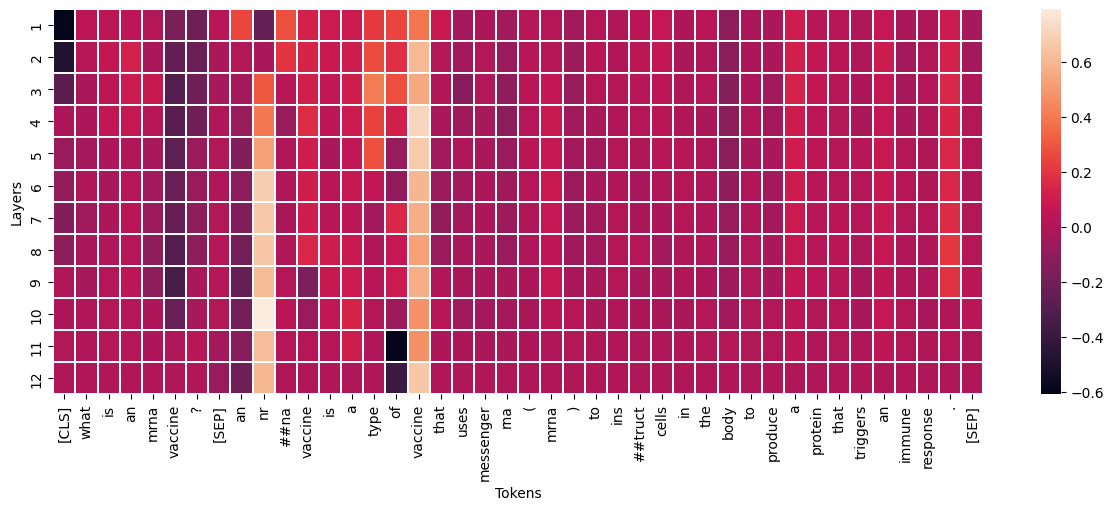

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))
xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_start), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2)
plt.xlabel('Tokens')
plt.ylabel('Layers')
plt.show()

On visualise ici dans une heatmap les attributions des différentes couches du modèle.

En abscisse, les token étudiés (chaque colonne de la heatmap représente donc l'évolution d'un token au fil des couches).

En ordonnée, les couches du modèle (il y en a 12).

Par exemple, dans la heatmap ci-dessus, le seul token qui influe positivement sur le début de la réponse est [CLS] (et cela devient visible à partir de la 11e couche du modèle uniquement).


Finalement, ce graphique permet de visualiser comment chaque couche du modèle a contribué à l'attribution des tokens dans un texte donné, et comment les attributions varient en fonction des tokens et des couches.

Cela est utile pour comprendre quel token est le plus influent dans la prédiction du modèle et comment les différentes couches de notre modèle ont contribué à cette influence.

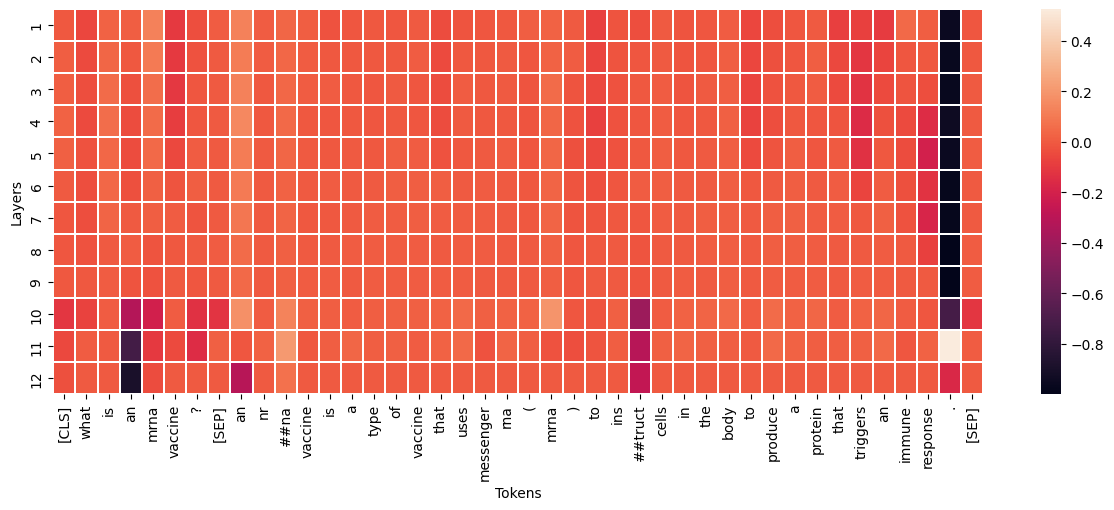

In [ ]:
fig, ax = plt.subplots(figsize=(15,5))

xticklabels=all_tokens
yticklabels=list(range(1,13))
ax = sns.heatmap(np.array(layer_attrs_end), xticklabels=xticklabels, yticklabels=yticklabels, linewidth=0.2) #, annot=True
plt.xlabel('Tokens')
plt.ylabel('Layers')

plt.show()

Les boxplots ci-dessous montrent, pour chaque couche, la distribution de l'attribution pour un token fixé.

Chaque couche peut en effet avoir plusieurs attributions différentes pour le même token, selon les exemples choisis, et le boxplot permet de visualiser cette variation pour chaque couche.


Cette représentation graphique permet donc de répondre à des questions telles que :

- Est-ce qu'une couche particulière a une attribution plus large ou plus concentrée ?
- Y a-t-il des couches où les attributions sont particulièrement extrêmes ou différentes ?
- Les attributions changent-elles significativement entre les couches, ou sont-elles relativement constantes ?

Cela permet, finalement, de mieux comprendre comment le modèle "répartit" l'importance du token spécifique à travers les différentes couches.

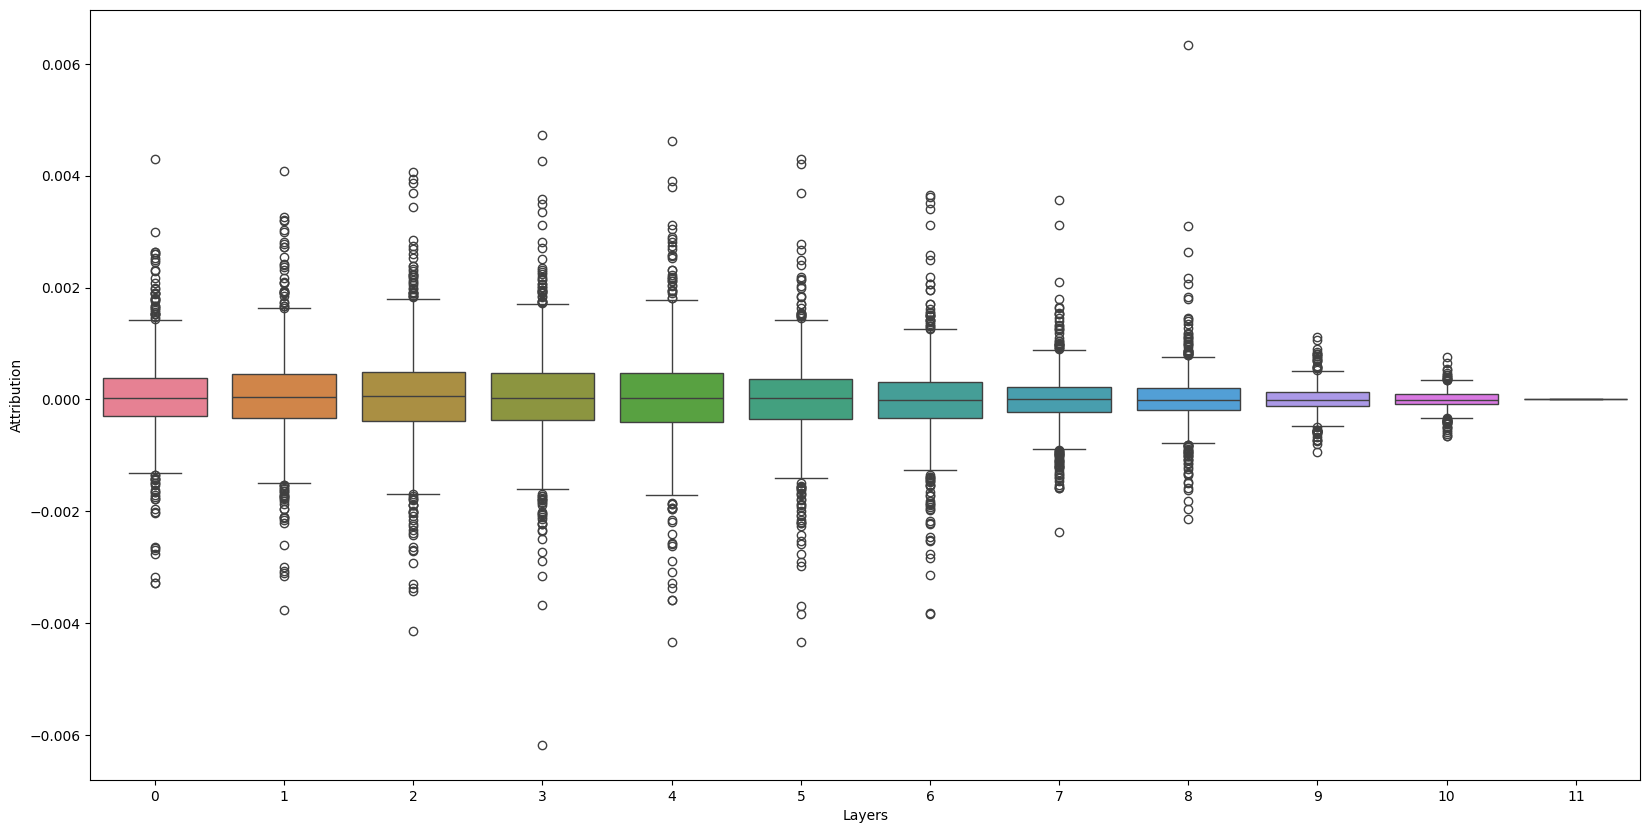

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_start_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

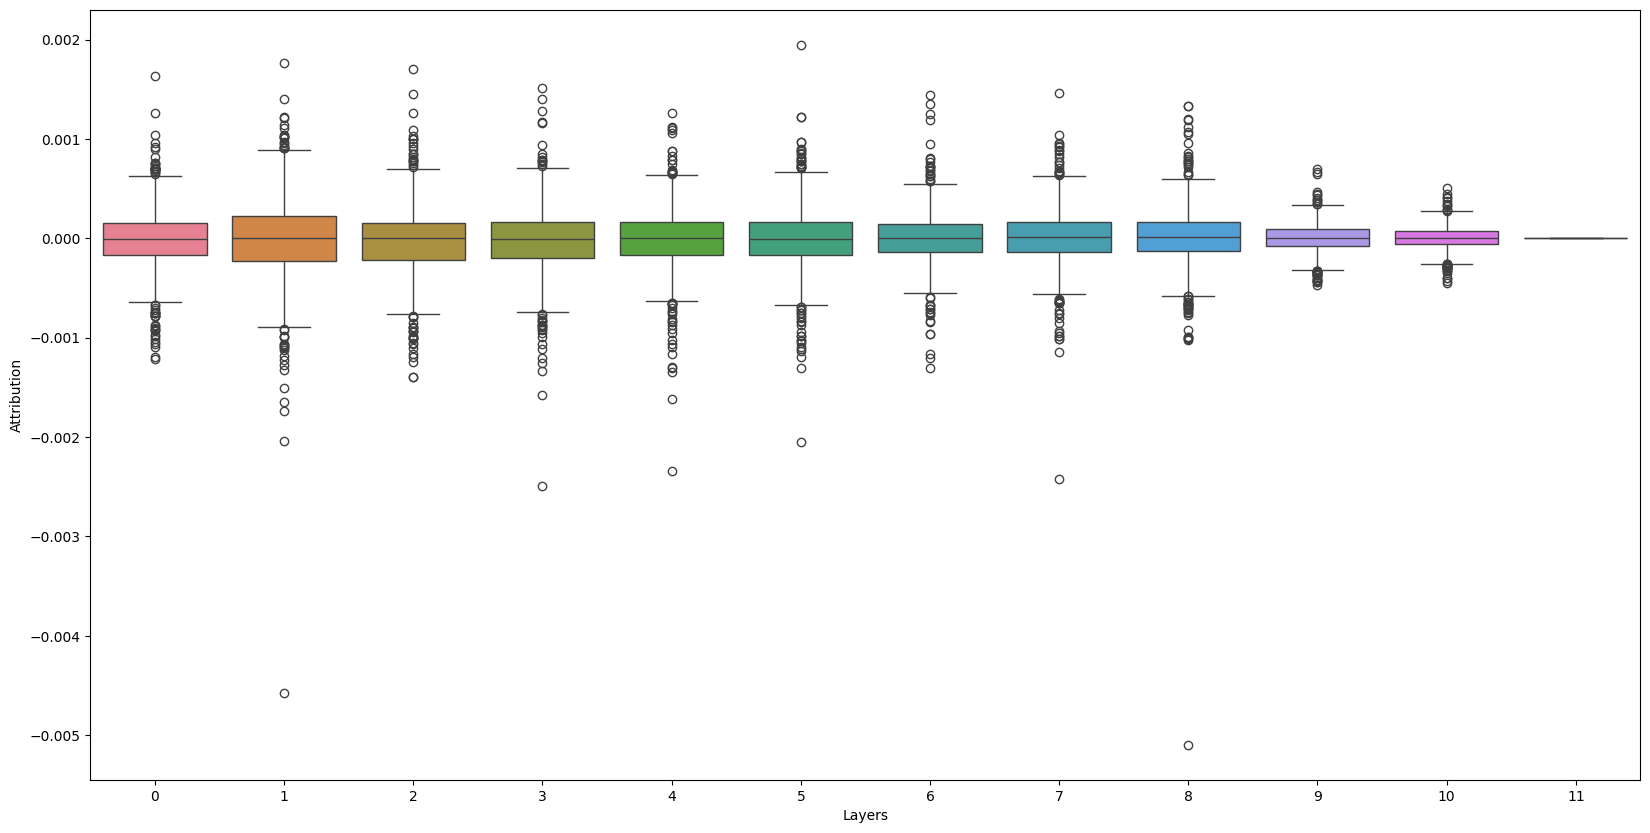

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.boxplot(data=layer_attrs_end_dist)
plt.xlabel('Layers')
plt.ylabel('Attribution')
plt.show()

In [ ]:
def pdf_attr(attrs, bins=100):
    return np.histogram(attrs, bins=bins, density=True)[0]

La fonction pdf_attr sert à calculer l'estimation de la densité de probabilité (PDF : Probability Density Function) à partir d'un ensemble de valeurs (attributions).
Cela visualise la distribution des valeurs d'attribution sous forme d'un histogramme normalisé.

In [ ]:
layer_attrs_end_pdf = map(lambda layer_attrs_end_dist: pdf_attr(layer_attrs_end_dist), layer_attrs_end_dist)
layer_attrs_end_pdf = np.array(list(layer_attrs_end_pdf))

# summing attribution along embedding diemension for each layer
# size: #layers
attr_sum = np.array(layer_attrs_end_dist).sum(-1)

# size: #layers
layer_attrs_end_pdf_norm = np.linalg.norm(layer_attrs_end_pdf, axis=-1, ord=1)

#size: #bins x #layers
layer_attrs_end_pdf = np.transpose(layer_attrs_end_pdf)

#size: #bins x #layers
layer_attrs_end_pdf = np.divide(layer_attrs_end_pdf, layer_attrs_end_pdf_norm, where=layer_attrs_end_pdf_norm!=0)

Le script (ci-dessus) calcule la PDF (Probability Density Function) pour chaque couche.

Puis il effectue la somme des attributions le long de la dernière dimension pour chaque couche.
   
Ensuite, chaque colonne (couche) de la PDF est normalisée en fonction de sa norme L1 pour s'assurer que les densités sont proportionnelles et que la somme des valeurs dans chaque colonne est égale à 1.

Enfin, la structure des données est modifiée, en transposant la matrice pour avoir les bins sur l'axe des lignes, et les couches sur l'axe des colonnes.

Cela nous fournit layer_attrs_end_pdf, qui est une matrice normalisée de densité de probabilité où chaque colonne représente une couche du modèle et chaque ligne représente un bin de l'estimation de la densité de probabilité ;
et attr_sum, qui est la somme des attributions pour chaque couche.

Cela est utile pour analyser la distribution des attributions à travers différentes couches et comprendre comment chaque couche contribue à la décision du modèle. La normalisation permet de comparer les attributions entre les couches en les mettant à la même échelle.


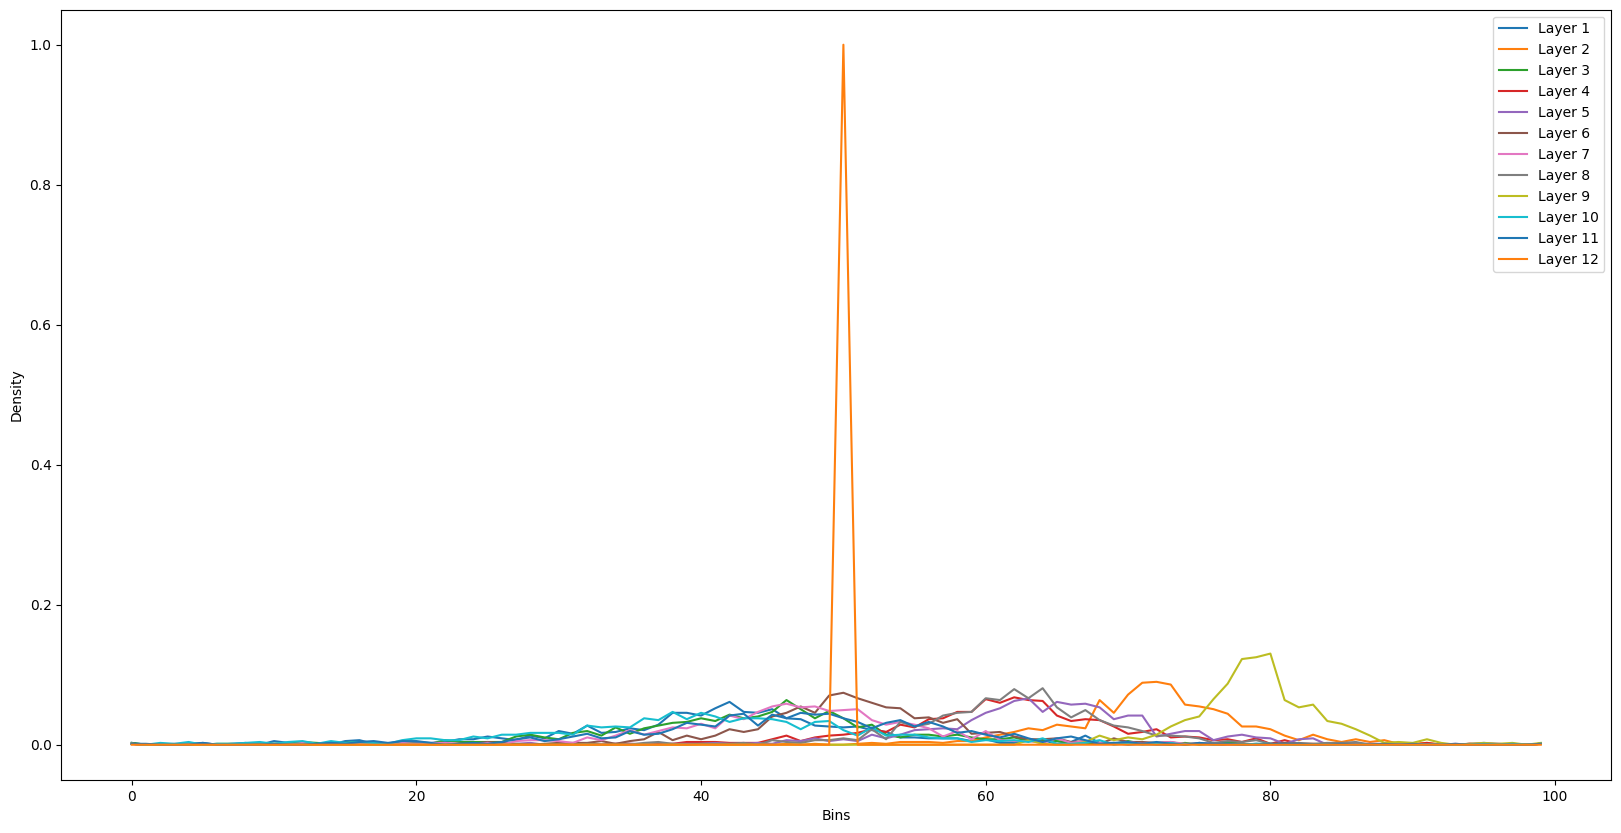

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(layer_attrs_end_pdf)
plt.xlabel('Bins')
plt.ylabel('Density')
plt.legend(['Layer '+ str(i) for i in range(1,13)])
plt.show()

Le graphique généré montre les distributions des attributions à travers les couches du modèle, en traçant une courbe de densité pour les attributions de chaque couche. Pour cela, il utilise les résultats des instructions créant la normalisation des densités de probabilité (PDF).
Les courbes permettent de visualiser la variation des attributions au fur et à mesure que les tokens passent à travers les différentes couches du modèle : cela nous permet de mieux comprendre la contribution des différentes couches dans le traitement du texte. .

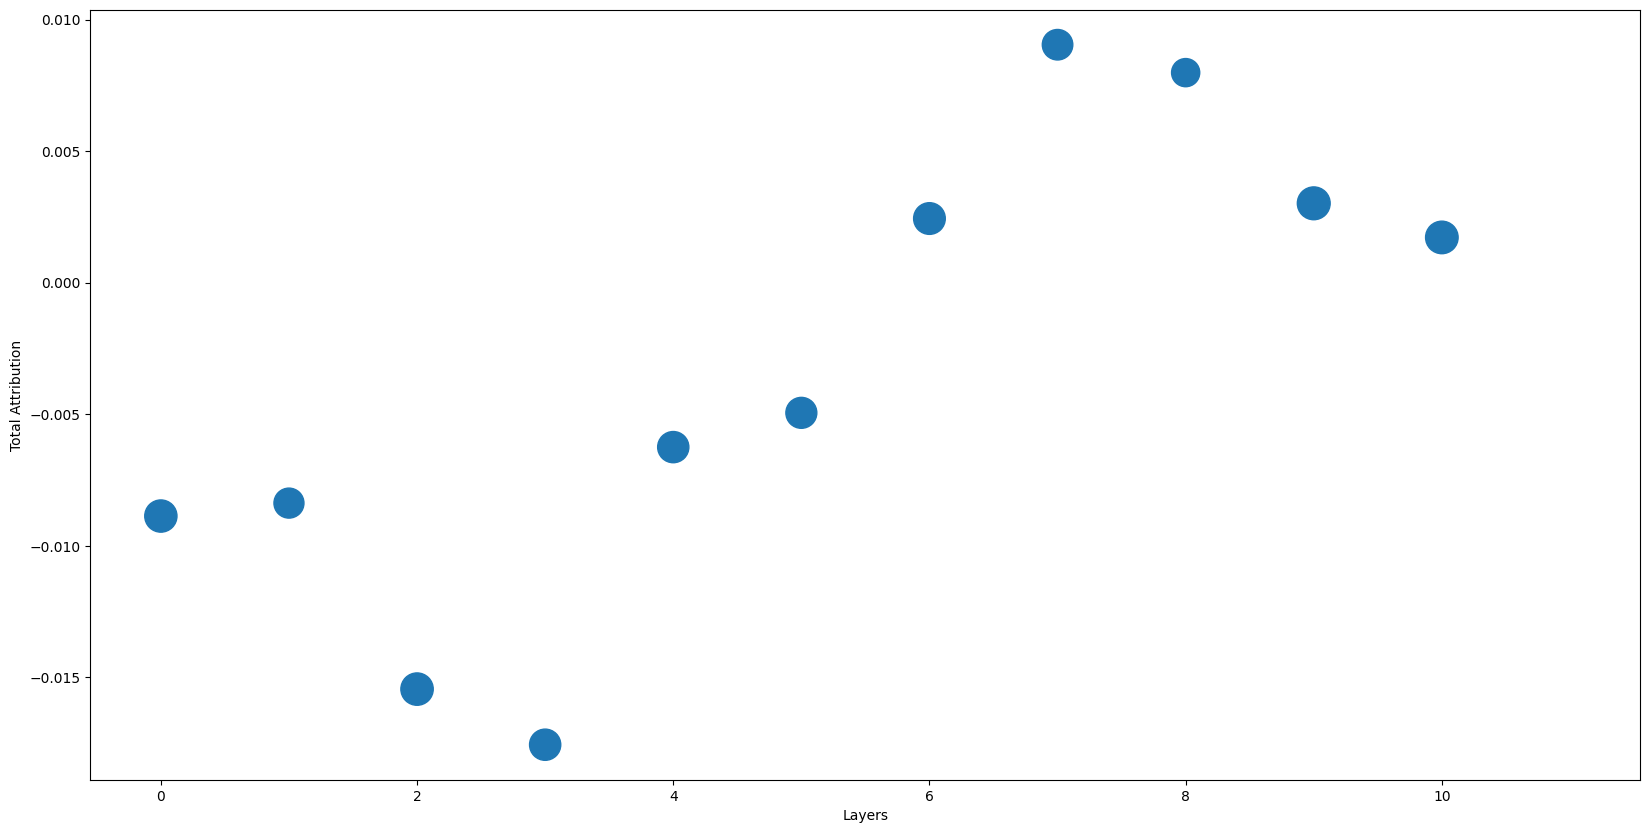

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))

# replacing 0s with 1s. np.log(1) = 0 and np.log(0) = -inf
layer_attrs_end_pdf[layer_attrs_end_pdf == 0] = 1
layer_attrs_end_pdf_log = np.log2(layer_attrs_end_pdf)

# size: #layers
entropies= -(layer_attrs_end_pdf * layer_attrs_end_pdf_log).sum(0)

plt.scatter(np.arange(12), attr_sum, s=entropies * 100)
plt.xlabel('Layers')
plt.ylabel('Total Attribution')
plt.show()

Le code ci-dessus génère un graphique de dispersion qui compare la somme des attributions totales (attr_sum) de chaque couche à l'entropie de chaque couche.

- L'axe des abscisses (X) représente les différentes couches du modèle (de Layer 1 à Layer 12).
- L'axe des ordonnées (Y) représente la somme des attributions pour chaque couche (comment les attributions totales sont réparties parmi les couches).
- La taille des points doit être déterminée par l'entropie de chaque couche :
        * Les couches avec une plus grande entropie auront des points plus grands, indiquant une plus grande incertitude ou une plus grande dispersion des attributions.
        * Les couches avec une entropie faible auront des points plus petits, indiquant que les attributions sont concentrées autour de certaines valeurs.

Une grande entropie signifie que les attributions sont plus uniformément réparties, tandis qu'une faible entropie signifie que les attributions sont concentrées sur quelques tokens ou valeurs.
Cela peut être utile pour comprendre si certaines couches sont plus "focalisées" sur des tokens spécifiques, tandis que d'autres couches ont des attributions plus réparties ou diversifiées.